In [1]:
#Testing Jupyter Notebook working on vscode with remote server connected ssh
print('hi')

hi


In [2]:
import os,sys
from pathlib import Path

import numpy as np
import torch
import pickle

In [3]:
x_train = np.load(Path("./selfharm-skeleton/train_data.npy"))
y_train = pickle.load(open("./selfharm-skeleton/train_label.pkl",'rb'))
x_test = np.load(Path("./selfharm-skeleton/val_data.npy"))
y_test = pickle.load(open("./selfharm-skeleton/val_label.pkl",'rb'))

x_train.shape, x_test.shape

((62, 3, 1000, 18, 1), (37, 3, 1000, 18, 1))

In [4]:
# x_train[0].reshape((1000,18,3))

In [5]:
for r,d,f in os.walk(Path("./cctv_vid")):
    print(f"root:{r}, dirs:{len(d)},files:{len(f)}")

root:cctv_vid, dirs:2,files:0
root:cctv_vid/selfharm, dirs:0,files:48
root:cctv_vid/normal, dirs:0,files:51


In [6]:
# keypoint check
import matplotlib.pyplot as plt

In [7]:
x_train = x_train.squeeze()
x_train.shape

(62, 3, 1000, 18)

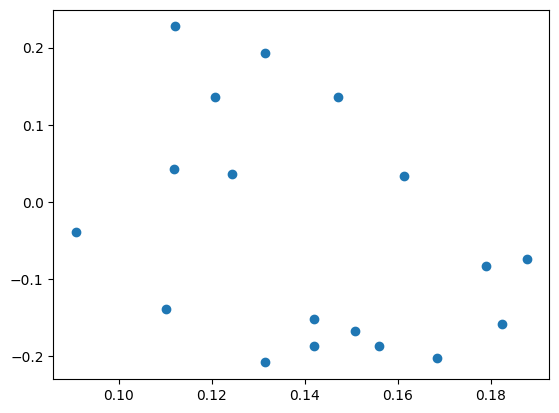

In [8]:
x, y = x_train[0,:2,0,:]
plt.scatter(x, y)
plt.show()

In [9]:
import os,sys
sys.path.append("./st-gcn")

In [10]:
import st_gcn

In [11]:
device = torch.device('cuda:0')
device

device(type='cuda', index=0)

In [12]:
stgcn = st_gcn.net.st_gcn.Model(
    num_class = 400, channel = 3, window_size=1000,
    num_person=1,
  num_point=18,
  dropout=0,
  graph="st_gcn.graph.Kinetics",
  graph_args = {"labeling_mode": 'spatial'}, mask_learning=True,
  use_data_bn=True,
    ).to(device)


In [13]:
os.getcwd()

'/home/plass-oneshot/0hyun'

In [14]:
from collections import OrderedDict
import torch
weights = "./st-gcn/model/kinetics-st_gcn.pt"
weights = torch.load(weights)

weights = OrderedDict(
                [
                    [k.split("module.")[-1], v]
                    for k, v in weights.items()
                ]
            )

for w in ["data_bn.weight","data_bn.bias","data_bn.running_mean","data_bn.running_var"]:
    weights.pop(w,None)
try:
    stgcn.load_state_dict(weights)
except:
    state = stgcn.state_dict()
    diff = list(set(state.keys()).difference(set(weights.keys())))
    print("Can not find these weights:")
    for d in diff:
        print("  " + d)
    state.update(weights)
    stgcn.load_state_dict(state)

Can not find these weights:
  backbone.6.down1.bn.num_batches_tracked
  person_bn.num_batches_tracked
  backbone.1.tcn1.bn.num_batches_tracked
  backbone.1.gcn1.bn.num_batches_tracked
  data_bn.running_mean
  backbone.0.tcn1.bn.num_batches_tracked
  backbone.6.tcn1.bn.num_batches_tracked
  backbone.8.gcn1.bn.num_batches_tracked
  tcn0.bn.num_batches_tracked
  backbone.8.tcn1.bn.num_batches_tracked
  backbone.2.gcn1.bn.num_batches_tracked
  backbone.3.tcn1.bn.num_batches_tracked
  backbone.6.gcn1.bn.num_batches_tracked
  backbone.2.tcn1.bn.num_batches_tracked
  backbone.4.tcn1.bn.num_batches_tracked
  backbone.4.gcn1.bn.num_batches_tracked
  backbone.5.tcn1.bn.num_batches_tracked
  backbone.5.gcn1.bn.num_batches_tracked
  backbone.3.down1.bn.num_batches_tracked
  backbone.0.gcn1.bn.num_batches_tracked
  data_bn.num_batches_tracked
  data_bn.weight
  backbone.7.tcn1.bn.num_batches_tracked
  gcn0.bn.num_batches_tracked
  backbone.7.gcn1.bn.num_batches_tracked
  data_bn.running_var
  backb

In [15]:
for i in stgcn.parameters():
    i.requires_grad = False


In [16]:
# fc_input_dim = net.fc.in_features
import torch.nn as nn

# net.fc = nn.Linear(fc_input_dim, 2)
in_features = stgcn.fcn.in_channels
stgcn.fcn = nn.Conv1d(in_features,2,kernel_size=(1,))


In [17]:
for i in stgcn.fcn.parameters():
    print(i.requires_grad)

True
True


In [18]:
x_train.shape, len(y_train[0])

((62, 3, 1000, 18), 62)

In [19]:
stgcn.to(device)
y = stgcn(torch.tensor(x_train).unsqueeze(-1).to(device))

In [20]:
loss = nn.CrossEntropyLoss().to(device)
y.shape, 

(torch.Size([62, 2]),)

In [21]:
y_target = torch.tensor(y_train[1],requires_grad=False).to(device)
y_target = y_target
y_target.shape

torch.Size([62])

In [22]:
print(y.device,y_target.device)
print(y.shape,y_target.shape)

cuda:0 cuda:0
torch.Size([62, 2]) torch.Size([62])


In [23]:
loss(y,y_target)

tensor(0.7330, device='cuda:0', grad_fn=<NllLossBackward0>)

In [24]:
x_train = np.load(Path("./selfharm-skeleton/train_data.npy"))
y_train = pickle.load(open("./selfharm-skeleton/train_label.pkl",'rb'))
x_test = np.load(Path("./selfharm-skeleton/val_data.npy"))
y_test = pickle.load(open("./selfharm-skeleton/val_label.pkl",'rb'))

x_train = torch.tensor(x_train).to(device)
y_train = torch.tensor(y_train[1],requires_grad=False).to(device)
x_test =  torch.tensor(x_test).to(device)
y_test = torch.tensor(y_test[1],requires_grad=False).to(device)
x_train.shape,y_train.shape,x_test.shape,y_test.shape

(torch.Size([62, 3, 1000, 18, 1]),
 torch.Size([62]),
 torch.Size([37, 3, 1000, 18, 1]),
 torch.Size([37]))

In [25]:
import torch.optim as optim
epochs = 100
optimizer = optim.Adam(stgcn.parameters(), lr=0.001)
for i in range(epochs):
    stgcn.train()
    output = stgcn(x_test)
    optimizer.zero_grad()

    l = loss(output,y_test)
    l.backward()
    optimizer.step()
    print(i)
    _, preds = torch.max(output, 1)
    print(f'loss : {l}, acc:{(preds== y_test).sum().item() / len(y_test)}')
    
    
    with torch.no_grad():
        stgcn.eval()
        output = stgcn(x_train)
        _, preds = torch.max(output, 1)
        print(f"eval loss : {loss(output,y_train)},acc:{(preds== y_train).sum().item() / len(y_train)}")





0
loss : 0.7575473189353943, acc:0.10810810810810811
eval loss : 0.757676899433136,acc:0.4838709677419355
1
loss : 0.6792033910751343, acc:0.2702702702702703
eval loss : 0.7085791826248169,acc:0.4838709677419355
2
loss : 0.6204613447189331, acc:0.40540540540540543
eval loss : 0.6741978526115417,acc:0.532258064516129
3
loss : 0.5785360932350159, acc:0.43243243243243246
eval loss : 0.6494091749191284,acc:0.8709677419354839
4
loss : 0.5485681891441345, acc:0.43243243243243246
eval loss : 0.6301261186599731,acc:0.5161290322580645
5
loss : 0.5263471007347107, acc:0.43243243243243246
eval loss : 0.6143507361412048,acc:0.5161290322580645
6
loss : 0.5090533494949341, acc:0.43243243243243246
eval loss : 0.6031399965286255,acc:0.5161290322580645
7
loss : 0.494942843914032, acc:0.43243243243243246
eval loss : 0.5974999070167542,acc:0.5161290322580645
8
loss : 0.4829401969909668, acc:0.43243243243243246
eval loss : 0.5991284251213074,acc:0.5161290322580645
9
loss : 0.4723682403564453, acc:0.432432